In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck

import hydra
from hydra.experimental import initialize, compose

torch.manual_seed(4444)
np.random.seed(4444)

# Create Dataset

In [2]:
with initialize(config_path="conf"):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

In [3]:
n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

length = cfg_model.length # each observation is a vector of size (1,length)

## Generate documents

In [4]:
#X = sin_cos(n, length)
#X = wind(num_elems=length)

X1 = arma(n//3, length, ar=[-0.5, 0, 0, 0] , ma=[0.5, 0, 0, 0])
X2 = arma(n//3, length, ar=[0,  0.7, 0, 0] , ma=[0, 0.8, 0, 0])
X3 = arma(n//3, length, ar=[0, 0, 0, -0.6] , ma=[0, 0, 0, 0.7])
X = np.r_[X1,X2,X3]
np.random.shuffle(X)

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]
print("shape of X_train, X_valid, X_test:", X_train.shape, X_valid.shape, X_test.shape)

shape of X: torch.Size([1200, 1, 64])
shape of X_train, X_valid, X_test: torch.Size([1000, 1, 64]) torch.Size([100, 1, 64]) torch.Size([100, 1, 64])


# Model

In [5]:
model = VCAE(cfg_model)

## Train

In [6]:
train_losses, valid_losses = train(model, cfg_train, X_train, X_valid)

EPOCH 10 train loss: 2.592958401888609, valid loss: 2.3683280050754547
epochs without improvement: 0

EPOCH 20 train loss: 2.264061626046896, valid loss: 2.0812710225582123
epochs without improvement: 0

EPOCH 30 train loss: 2.1777355149388313, valid loss: 2.0310548543930054
epochs without improvement: 3

EPOCH 40 train loss: 2.116326831281185, valid loss: 1.9659388661384583
epochs without improvement: 0

EPOCH 50 train loss: 2.0983175076544285, valid loss: 1.9445578753948212
epochs without improvement: 3

EPOCH 60 train loss: 2.083829239010811, valid loss: 1.9412358105182648
epochs without improvement: 5

EPOCH 70 train loss: 2.0550499260425568, valid loss: 1.9246591925621033
epochs without improvement: 0

EPOCH 80 train loss: 2.0644847340881824, valid loss: 1.934222936630249
epochs without improvement: 8

EPOCH 90 train loss: 1.9418595395982265, valid loss: 1.865916758775711
epochs without improvement: 1

EPOCH 100 train loss: 1.910139311105013, valid loss: 1.8169057965278625
epochs 

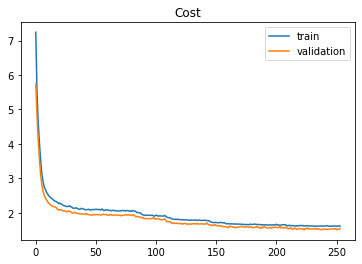

In [7]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [8]:
#torch.save(model.state_dict(), "../saved_weights/wind64_model")
#model.load_state_dict(torch.load("../saved_weights/wind6_model"))

# Testing

## Average and std correlation

avg and std: 0.39932554945054943 0.2525561571755803

cor: 0.15700549450549448
cor: 0.765613553113553
cor: 0.3636904761904762
cor: 0.29148351648351645


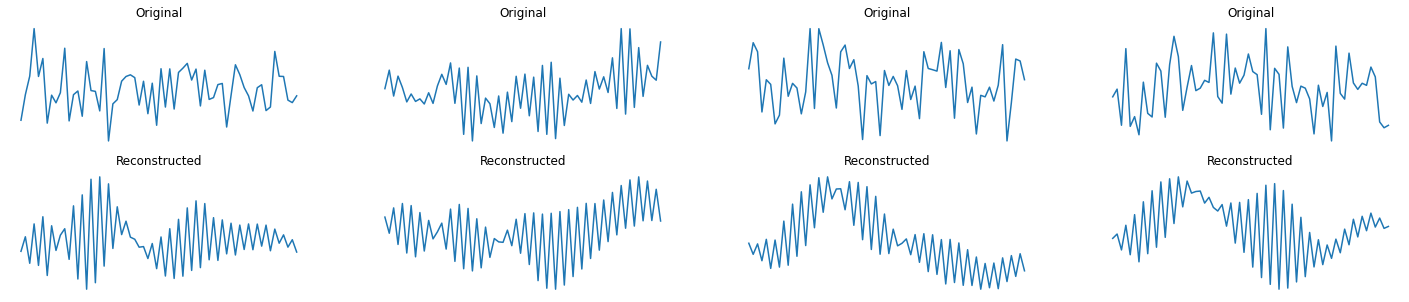

In [9]:
pred = model(X_test).detach().numpy()

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], X_test[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(X_test[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], X_test[start+i,0]).correlation)

# Latent space

In [10]:
if cfg_model.bottleneck_nn == 2:
    latent_space(model, n=10)

# Choose bootleneck

In [11]:
#vals = choose_bottleneck(X_test, X_train, X_valid, length, M, Lf)
#plt.plot([np.mean(x) for x in vals], "-o", [1]*len(vals))

# Checking important filters

<AxesSubplot:>

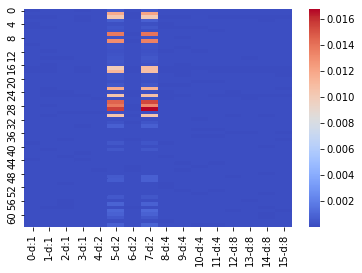

In [12]:
num_filter = 4*cfg_model.M
w_per_filter = cfg_model.length-cfg_model.Lf+1 # weights per filter
num_neurons = cfg_model.bottleneck_nn
M = cfg_model.M 

if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation

# Clustering using bootlenecks

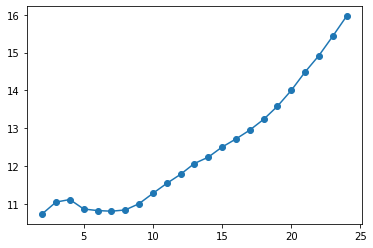

In [13]:
bns = model(X_test, get_bottleneck=True).detach().numpy()
chs = []
for i in range(2,25):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(bns) 
    clus = clustering.labels_
    ch = calinski_harabasz_score(bns,clus)
    chs.append(ch)
plt.plot(range(2,len(chs)+2), chs, "o-")

In [14]:
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(bns)
clus = clustering.labels_

In [15]:
if bns.shape[1] <= 10: # more than 10 plots is slow
    sns.pairplot(pd.DataFrame(np.c_[bns,clus]), hue=bns.shape[1])

<AxesSubplot:>

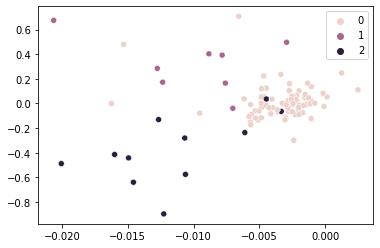

In [16]:
d1, d2 = 0, 1
sns.scatterplot(x=bns[:,d1], y=bns[:,d2], hue=clus)